In [1]:
import json
from collections import Counter
import networkx as nx
import pymorphy2
analyzer = pymorphy2.MorphAnalyzer()
# %config InlineBackend.figure_format='retina'

In [2]:
with open('norm_tokenized_corpus.json', 'r') as f:
   corpus = json.load(f)

corpus[0][:10]

['миф',
 'обязательный',
 'вибрация',
 'выход',
 'тело',
 'практика',
 'вибрация',
 'это',
 'признак',
 'скорый']

### Поскольку ключевыми словами могут быть только существительные, удалим все остальные слова

In [3]:
stop_w = {'ос', 'мочь'}

nouns_corpus = []
for doc in corpus:
    nouns_doc = [word for word in doc if word not in stop_w and analyzer.parse(word)[0].tag.POS == 'NOUN']
    if nouns_doc:
        nouns_corpus.append(nouns_doc)

print(len(corpus))
print(len(nouns_corpus))
nouns_corpus[0][:10]

278
271


['миф',
 'вибрация',
 'выход',
 'тело',
 'практика',
 'вибрация',
 'признак',
 'выход',
 'тело',
 'выход']

### Посчитаем количество вхождений каждого из существительных, выделим 20 наиболее частотных

In [4]:
N_KEYWORDS = 15

In [5]:
flat_corpus = [word for doc in nouns_corpus for word in doc]
counter = Counter(flat_corpus)
counter_sorted = dict(sorted(counter.items(),
                             key=lambda item: item[1], reverse=True))
print(len(counter_sorted))
list(counter_sorted.items())[:N_KEYWORDS]

3075


[('сон', 1305),
 ('человек', 339),
 ('время', 240),
 ('сновидение', 193),
 ('тело', 170),
 ('рука', 124),
 ('жизнь', 119),
 ('астрал', 108),
 ('мозг', 98),
 ('реальность', 97),
 ('мир', 93),
 ('вопрос', 92),
 ('выход', 90),
 ('день', 89),
 ('практика', 88)]

### Определим веса для графа: для каждого ключевого слова посчитаем количество его вхождений в документ при одновременном вхождении других ключевых слов

In [6]:
keywords = list(counter_sorted.keys())[:N_KEYWORDS]
weights_counter = Counter()

for keyword_i in keywords:
    for keyword_j in keywords:
        if keyword_i != keyword_j:
            for doc in nouns_corpus:
                if (keyword_i in doc and keyword_j in doc) \
                    and (not weights_counter[(keyword_j, keyword_i)]):
                    weights_counter[(keyword_i, keyword_j)] += 1

edge_weights = [(item[0][0], item[0][1], item[1]) for item in weights_counter.items() if item[1] > 2]
edge_weights[:5]

[('сон', 'человек', 81),
 ('сон', 'время', 94),
 ('сон', 'сновидение', 68),
 ('сон', 'тело', 55),
 ('сон', 'рука', 39)]

### С помощью Gephi вершины графа имеют размер, пропорциональный степени. Ребра графа также пропорциональны найденным весам.

In [7]:
G = nx.Graph()
G.add_weighted_edges_from(edge_weights)
nx.write_gexf(G, 'lucid_dreams.gexf')

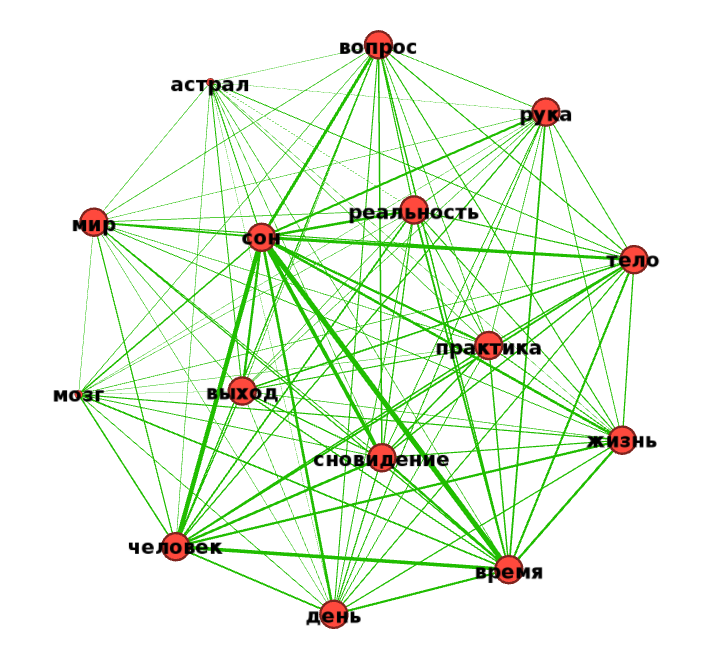

### Сильная связь "сна" и "времени" может быть обусловлена рекомендациями, описанием и т.д. того, что про происходит "во время сна". "Вопрос" попал в наиболее частотные слова, вероятно, потому что пользователи задают вопросы и получают ответы в специальной рубрике, также админом проводятся вебинары. Примечательна связь "сон" и "день" - может быть, речь идет о практике осознанных сновидений в дневное время. Вершина "астрал" сильнее всего связана с "телом" - это легко объяснить: существует практика выхода из тела, в этом состоянии возможно перемещение между мирами и т.д., в т.ч. выход в астрал. Влиять на свое состояние и фиксировать его можно с помощью физического тела:
_"Вы можете попасть в ложное пробуждение. Это когда вы вроде бы проснулись, но оказываетесь в новом сне. Это лечится особыми техниками, которые называются тестом на реальность. Например, попробуйте зажать нос и подышать. Или попробуйте проткнуть пальцем свою ладонь. Если получается – вы всё ещё вне тела или во сне."_

## Вывод
### В ходе проделанной работы были выделены наиболее частотные слова, зафиксированы количественные связи между словами. Полученные данные отображены на графе, визуализированы веса ребер и степени вершин.